In [1]:
from itertools import islice, combinations, product
from collections import defaultdict
from goatools import obo_parser
from functools import partial

import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline
sns.set()
pd.set_option("display.max_columns", 50)

DATA_DIRECTORY = "/home/clusterduck123/Desktop/git/supplements/data"
RAW_DATA_DIRECTORY = f"{DATA_DIRECTORY}/raw-data"
YEAST_DIRECTORY = f"{DATA_DIRECTORY}/processed-data/organisms/yeast"
NETWORK_DIRECTORY = f"{YEAST_DIRECTORY}/networks"
MATRIX_DIRECTORY  = f"{YEAST_DIRECTORY}/distance-matrices"
ANNOTATION_DIRECTORY  = f"{YEAST_DIRECTORY}/annotations"

# Preprocessing

In [3]:
namespace = 'BP'
correction = 'BH'

alpha = 0.05
lb_GO = 5
ub_GO = 500
min_lvl = 0
max_lvl = 100

In [4]:
PPI = nx.read_edgelist(f"{NETWORK_DIRECTORY}/PPI_BioGRID.txt")

annotation_df = pd.read_csv(f"{ANNOTATION_DIRECTORY}/GO_{namespace}_BioGRID-SGD.csv")

go_dag = obo_parser.GODag(f"{RAW_DATA_DIRECTORY}/go-basic.obo")

gene_population = set(PPI.nodes())
GO_population = {go_id for go_id in set(annotation_df.GO_ID) 
                           if (lb_GO <= len(annotation_df[annotation_df.GO_ID == go_id]) <= ub_GO and
                               min_lvl <= go_dag[go_id].level <= max_lvl)}

annotation_df = annotation_df[annotation_df.GO_ID.isin(GO_population)]

/home/clusterduck123/Desktop/git/supplements/data/raw-data/go-basic.obo: fmt(1.2) rel(2019-10-07) 47,285 GO Terms


In [5]:
# Conversion dictionaries
GO2genes = pd.Series({go_id: set(genes.Systematic_ID) for go_id, genes in annotation_df.groupby('GO_ID')}, 
                     name='nb_genes')
gene2GO = defaultdict(set)
gene2GO  = {gene : set(go_ids.GO_ID)        for gene, go_ids in annotation_df.groupby('Systematic_ID')}
global_GO_counter = GO2genes.apply(len)

In [6]:
def get_number_of_pre_runs(PVALUE_DIRECTORY, n_clusters = 99):
    splitted_file_names = [name.split('_') for name in os.listdir(PVALUE_DIRECTORY)]
    pre_runs = [int(run) for run, ncluster, db_txt in splitted_file_names if ncluster == str(n_clusters)]
    if pre_runs:
        return max(pre_runs)+1
    else:
        return 0

# Load

In [7]:
def get_enrichments(alpha, p_values, cluster_list, correction):
    relevant_p_values = [p_values[str(cluster_idx)][cluster2GO(cluster)] 
                             for cluster_idx,cluster in enumerate(cluster_list)] 
    
    sorted_p_values = sorted(p for p_cluster in relevant_p_values
                               for p in p_cluster)
    m = len(sorted_p_values)
    if   correction == 'BY':
        c = np.log(m) + np.euler_gamma + 1/(2*m)
    elif correction == 'BH':
        c = 1
    else:
        print("Correction not known!")
        raise Exception
    for k,P_k in enumerate(sorted_p_values,1):
        if P_k > k/(m*c) * alpha:
            break
    threshold = sorted_p_values[k-2]
    return p_values < threshold


def cluster2GO(cluster):
    return set.union(*(gene2GO.get(gene, set()) for gene in cluster))

def is_annotated_in(gene, GO_set):
    return not gene2GO.get(gene,set()).isdisjoint(GO_set)

In [8]:
cluster_coverages = {}
GO_coverages      = {}
gene_coverages    = {}

In [9]:
MIN_CLUSTERS = 2
MAX_CLUSTERS = 99
MAX_RUNS     = 30

cluster_coverages['GDV'] = defaultdict(pd.DataFrame)
GO_coverages['GDV']      = defaultdict(pd.DataFrame)
gene_coverages['GDV']    = defaultdict(pd.DataFrame)

## GDV

In [10]:
method = 'kmedoid'

for distance in ['mahalanobis', 'GDV-similarity',
    
                'cityblock',
                'euclidean',
                'chebyshev',
                
                'normalized1-l1',
                'normalized1-l2',
                'normalized1-linf',]:
    CLUSTER_DIRECTORY = f"{YEAST_DIRECTORY}/clusterings/GDV/{distance}/{method}"
    PVALUE_DIRECTORY = f"{YEAST_DIRECTORY}/enrichments/GDV/{distance}/{method}/{namespace}"
    runs = min(get_number_of_pre_runs(CLUSTER_DIRECTORY, MAX_CLUSTERS), MAX_RUNS)

    for run in range(runs):
        t1 = time.time()
        print(f"{distance} {run}")
        
        cluster_coverages['GDV'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS)) 
        GO_coverages[     'GDV'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS))
        gene_coverages[   'GDV'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS))
        
        for nb_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS):
            with open(f"{CLUSTER_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", 'r') as f:
                 cluster_list = [set(line.split()) for line in f]
            cluster_df = pd.Series({gene:cluster_idx 
                                        for cluster_idx,cluster in enumerate(cluster_list) 
                                        for gene in cluster})
            
            p_values = pd.read_csv(f"{PVALUE_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", index_col=0)

            enrichments = get_enrichments(alpha, p_values, cluster_list, correction)
            enrichmet_list = [set(enrichments[i][enrichments[i]].index) for i in enrichments.columns]
            
            cluster_coverages['GDV'][distance][run][nb_clusters] = sum(enrichments.any())      / nb_clusters
            GO_coverages[     'GDV'][distance][run][nb_clusters] = sum(enrichments.any(axis=1))/len(GO_population)
            gene_coverages[   'GDV'][distance][run][nb_clusters] = sum(is_annotated_in(gene,enrichmet_list[cluster_idx])
                                                             for gene, cluster_idx in cluster_df.items()) / len(PPI)
            t2 = time.time()
            print(f'{nb_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

mahalanobis 0
mahalanobis 1
mahalanobis 2
mahalanobis 3
mahalanobis 4
mahalanobis 5
mahalanobis 6
mahalanobis 7
mahalanobis 8
mahalanobis 9
mahalanobis 10
mahalanobis 11
mahalanobis 12
mahalanobis 13
mahalanobis 14
mahalanobis 15
mahalanobis 16
mahalanobis 17
mahalanobis 18
mahalanobis 19
mahalanobis 20
mahalanobis 21
mahalanobis 22
mahalanobis 23
mahalanobis 24
mahalanobis 25
mahalanobis 26
mahalanobis 27
mahalanobis 28
mahalanobis 29
98: 14.95sec
GDV-similarity 0
GDV-similarity 1
GDV-similarity 2
GDV-similarity 3
GDV-similarity 4
GDV-similarity 5
GDV-similarity 6
GDV-similarity 7
GDV-similarity 8
GDV-similarity 9
GDV-similarity 10
GDV-similarity 11
GDV-similarity 12
GDV-similarity 13
GDV-similarity 14
GDV-similarity 15
GDV-similarity 16
GDV-similarity 17
GDV-similarity 18
GDV-similarity 19
GDV-similarity 20
GDV-similarity 21
GDV-similarity 22
GDV-similarity 23
GDV-similarity 24
GDV-similarity 25
GDV-similarity 26
GDV-similarity 27
GDV-similarity 28
GDV-similarity 29
98: 10.72sec
city

## GCV-A

In [25]:
cluster_coverages['GCV-A'] = defaultdict(pd.DataFrame)
GO_coverages['GCV-A']      = defaultdict(pd.DataFrame)
gene_coverages['GCV-A']    = defaultdict(pd.DataFrame)

In [66]:
method = 'kmedoid'

for distance in [
                 #'all1_normalized1-l1', 'all2_normalized1-l1', 
                 'all1_normalized1-l2', 'all2_normalized1-l2',
                 'all1_normalized1-linf'
                ]:
    
    CLUSTER_DIRECTORY = f"{YEAST_DIRECTORY}/clusterings/GCV-A/{distance}/{method}"
    PVALUE_DIRECTORY = f"{YEAST_DIRECTORY}/enrichments/GCV-A/{distance}/{method}/{namespace}"
    runs = min(get_number_of_pre_runs(PVALUE_DIRECTORY, MAX_CLUSTERS), MAX_RUNS)

    for run in range(runs):
        t1 = time.time()
        print(f"{distance} {run}")
        
        cluster_coverages['GCV-A'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2)) 
        GO_coverages[     'GCV-A'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2))
        gene_coverages[   'GCV-A'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2))
        
        for nb_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS):
            with open(f"{CLUSTER_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", 'r') as f:
                 cluster_list = [set(line.split()) for line in f]
            cluster_df = pd.Series({gene:cluster_idx 
                                        for cluster_idx,cluster in enumerate(cluster_list) 
                                        for gene in cluster})
            
            p_values = pd.read_csv(f"{PVALUE_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", index_col=0)

            enrichments = get_enrichments(alpha, p_values, cluster_list, correction)
            enrichmet_list = [set(enrichments[i][enrichments[i]].index) for i in enrichments.columns]
            
            cluster_coverages['GCV-A'][distance][run][nb_clusters] = sum(enrichments.any())      / nb_clusters
            GO_coverages[     'GCV-A'][distance][run][nb_clusters] = sum(enrichments.any(axis=1))/len(GO_population)
            gene_coverages[   'GCV-A'][distance][run][nb_clusters] = sum(is_annotated_in(gene,enrichmet_list[cluster_idx])
                                                             for gene, cluster_idx in cluster_df.items()) / len(PPI)
            t2 = time.time()
            print(f'{nb_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

all1_normalized1-l2 0
all1_normalized1-l2 1
98: 12.43sec
all2_normalized1-l2 0
all2_normalized1-l2 1
98: 13.32sec
all1_normalized1-linf 0
all1_normalized1-linf 1
98: 11.92sec


# GCV-DG

In [83]:
cluster_coverages['GCV-DG'] = defaultdict(pd.DataFrame)
GO_coverages[     'GCV-DG'] = defaultdict(pd.DataFrame)
gene_coverages[   'GCV-DG'] = defaultdict(pd.DataFrame)

In [84]:
method = 'kmedoid'

for distance in [
                 'all1_normalized1-l1', 'all2_normalized1-l1', 
                 'all1_normalized1-l2', 'all2_normalized1-l2',
                 'all1_normalized1-linf'
                ]:
    
    CLUSTER_DIRECTORY = f"{YEAST_DIRECTORY}/clusterings/GCV-DG/{distance}/{method}"
    PVALUE_DIRECTORY  = f"{YEAST_DIRECTORY}/enrichments/GCV-DG/{distance}/{method}/{namespace}"
    runs = min(get_number_of_pre_runs(PVALUE_DIRECTORY, MAX_CLUSTERS), MAX_RUNS)

    for run in range(runs):
        t1 = time.time()
        print(f"{distance} {run}")
        
        cluster_coverages['GCV-DG'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2)) 
        GO_coverages[     'GCV-DG'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2))
        gene_coverages[   'GCV-DG'][distance][run] = pd.Series(np.nan, index=range(MIN_CLUSTERS, MAX_CLUSTERS+2))
        
        for nb_clusters in range(MIN_CLUSTERS, MAX_CLUSTERS):
            with open(f"{CLUSTER_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", 'r') as f:
                 cluster_list = [set(line.split()) for line in f]
            cluster_df = pd.Series({gene:cluster_idx 
                                        for cluster_idx,cluster in enumerate(cluster_list) 
                                        for gene in cluster})
            
            p_values = pd.read_csv(f"{PVALUE_DIRECTORY}/{run}_{nb_clusters}_BioGRID.txt", index_col=0)

            enrichments = get_enrichments(alpha, p_values, cluster_list, correction)
            enrichmet_list = [set(enrichments[i][enrichments[i]].index) for i in enrichments.columns]
            
            cluster_coverages['GCV-DG'][distance][run][nb_clusters] = sum(enrichments.any())      / nb_clusters
            GO_coverages[     'GCV-DG'][distance][run][nb_clusters] = sum(enrichments.any(axis=1))/len(GO_population)
            gene_coverages[   'GCV-DG'][distance][run][nb_clusters] = sum(is_annotated_in(gene,enrichmet_list[cluster_idx])
                                                             for gene, cluster_idx in cluster_df.items()) / len(PPI)
            t2 = time.time()
            print(f'{nb_clusters}: {t2-t1:.2f}sec', end='\r')
    print()

all1_normalized1-l1 0
all1_normalized1-l1 1
all1_normalized1-l1 2
all1_normalized1-l1 3
all1_normalized1-l1 4
all1_normalized1-l1 5
all1_normalized1-l1 6
all1_normalized1-l1 7
all1_normalized1-l1 8
all1_normalized1-l1 9
all1_normalized1-l1 10
all1_normalized1-l1 11
all1_normalized1-l1 12
all1_normalized1-l1 13
98: 12.99sec
all2_normalized1-l1 0
all2_normalized1-l1 1
all2_normalized1-l1 2
all2_normalized1-l1 3
all2_normalized1-l1 4
all2_normalized1-l1 5
all2_normalized1-l1 6
all2_normalized1-l1 7
all2_normalized1-l1 8
all2_normalized1-l1 9
all2_normalized1-l1 10
all2_normalized1-l1 11
all2_normalized1-l1 12
all2_normalized1-l1 13
98: 18.49sec
all1_normalized1-l2 0
all1_normalized1-l2 1
all1_normalized1-l2 2
all1_normalized1-l2 3
all1_normalized1-l2 4
all1_normalized1-l2 5
all1_normalized1-l2 6
all1_normalized1-l2 7
all1_normalized1-l2 8
all1_normalized1-l2 9
all1_normalized1-l2 10
all1_normalized1-l2 11
all1_normalized1-l2 12
all1_normalized1-l2 13
98: 18.30sec
all2_normalized1-l2 0
all

# Plots

In [142]:
name2string = {'GCV_tvd':'TVD', 'GCV_hellinger':'GCV_{hell}', 'GDV_GDV-similarity':'GDV-similiarity',
               
               'GDV_euclidean'  :'GDV_{L_2}'  , 'GCV_euclidean'  :'GCV_{eucl}'  , 
               'GDV_cityblock'  :'GDV_{L_1}'  , 'GCV_cityblock'  :'GCV_{city}'  , 
               'GDV_seuclidean' :'GDV_{seucl}' , 'GCV_seuclidean' :'GCV_{seucl}' ,
               'GDV_cosine'     :'GDV_{cos}'   , 'GCV_cosine'     :'GCV_{cos}'   ,
               'GDV_correlation':'GDV_{cor}'   , 'GCV_correlation':'GCV_{cor}'   ,
               'GDV_sqeuclidean':'GDV_{eucl^2}', 'GCV_sqeuclidean':'GCV_{eucl^2}',
               'GDV_chebyshev'  :'GDV_{L_{\infty}}' , 'GCV_chebyshev'  :'GCV_{cheby}' ,
               'GDV_canberra'   :'GDV_{can}'   , 'GCV_canberra'   :'GCV_{can}'   ,
               'GDV_braycurtis' :'GDV_{bray}'  , 'GCV_braycurtis' :'GCV_{bray}'  ,
               'GDV_mahalanobis':'GDV_{mahala}', 'GCV_mahalanobis':'GCV_{mahala}',
               
               'GDV_normalized1-l1': 'GDV_{nL_1}',
               'GDV_normalized1-l2': 'GDV_{nL_2}',
               'GDV_normalized1-linf': 'GDV_{nL_{\infty}}',
              
               
               'GCV-A_all1_normalized1-l1': 'GCV-A1_{nL_1}',
               'GCV-A_all2_normalized1-l1': 'GCV-A2_{nL_1}',
               
               'GCV-A_all1_normalized1-l2': 'GCV-A1_{nL_2}',
               'GCV-A_all2_normalized1-l2': 'GCV-A2_{nL_2}',
              
               'GCV-A_all1_normalized1-linf': 'GCV-A_{nL_{\infty}}',

               
               'GCV-DG_all1_normalized1-l1': "DA'-GCV-1_{nL_1}",
               'GCV-DG_all2_normalized1-l1': "DA'-GCV-2_{nL_1}",
               
               'GCV-DG_all1_normalized1-l2': "DA'-GCV-DG1_{nL_2}",
               'GCV-DG_all2_normalized1-l2': "DA'-GCV-DG2_{nL_2}",
              
               'GCV-DG_all1_normalized1-linf': "DA'-GCV_{nL_{\infty}}"}

In [143]:
plot_methods = [
                'GDV_mahalanobis',
                'GDV_GDV-similarity',
    
                #'GDV_cityblock',
                #'GDV_euclidean',
                #'GDV_chebyshev',
                
                #'GDV_normalized1-l1',
                #'GDV_normalized1-l2',
                'GDV_normalized1-linf',
    
                #'GCV-A_all1_normalized1-l1',
                #'GCV-A_all2_normalized1-l1',
                
                #'GCV-A_all1_normalized1-l2',
                #'GCV-A_all2_normalized1-l2',
               
                #'GCV-A_all1_normalized1-linf'
    
    
                'GCV-DG_all1_normalized1-l1',
                'GCV-DG_all2_normalized1-l1',
                
                #'GCV-DG_all1_normalized1-l2',
                #'GCV-DG_all2_normalized1-l2',
               
                #'GCV-DG_all1_normalized1-linf'

               ]

In [144]:
blues = sns.color_palette("Blues", 3)
reds  = sns.color_palette("Reds" , 3)
blacks= sns.color_palette("Greys" , 3)
whateva = sns.hls_palette(8, l=.3, s=.8)

colors = {
           'GDV_mahalanobis'   : whateva[0],
           'GDV_GDV-similarity': whateva[1],
    
           'GDV_cityblock' : whateva[7],
           'GDV_euclidean' : whateva[5],
           'GDV_chebyshev' : whateva[3],
                
           'GDV_normalized1-l1'  : whateva[7],
           'GDV_normalized1-l2'  : whateva[5],
           'GDV_normalized1-linf': whateva[3],
    
           #'GDV_canberra'
    
           'GCV-A_all1_normalized1-l1' : blacks[0],
           'GCV-A_all2_normalized1-l1' : blacks[1],
    
           'GCV-A_all1_normalized1-l2' : blacks[0],
           'GCV-A_all2_normalized1-l2' : blacks[1],
    
           'GCV-A_all1_normalized1-linf' : blacks[0],
    
            
           'GCV-DG_all1_normalized1-l1' : blacks[2],
           'GCV-DG_all2_normalized1-l1' : blacks[1],
    
           'GCV-DG_all1_normalized1-l2' : blacks[0],
           'GCV-DG_all2_normalized1-l2' : blacks[1],
    
           'GCV-DG_all1_normalized1-linf' : blacks[0],
               }

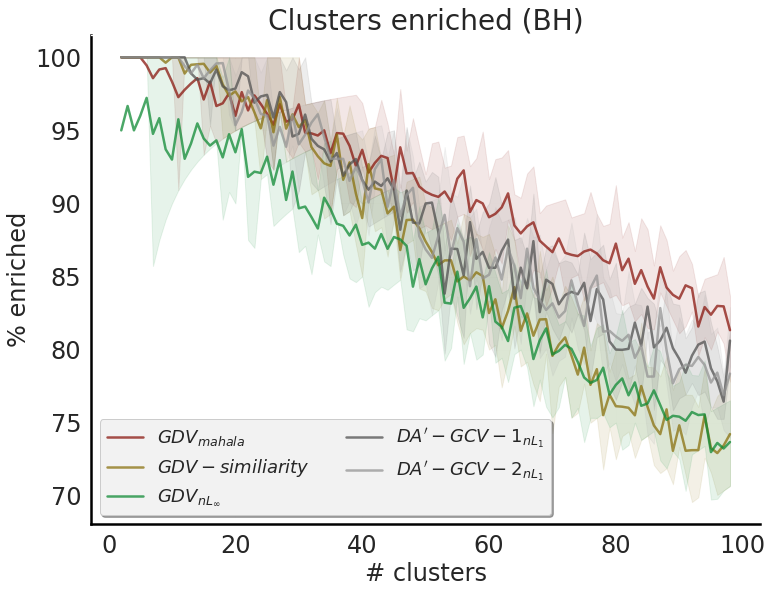

In [145]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(cluster_coverages[feature][distance].index, 100*cluster_coverages[feature][distance].T.mean(), 
            label     = f'${name2string[method]}$', 
            color    = colors[method], 
            linewidth = 2.5,
            alpha     = 0.75);
    
    ax.fill_between(cluster_coverages[feature][distance].index, 
                     100*cluster_coverages[feature][distance].T.quantile(0.25), 
                     100*cluster_coverages[feature][distance].T.quantile(0.75), 
                     color    = colors[method],
                     alpha=0.1,);
    ax.set_title(f'Clusters enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_cluster.png")

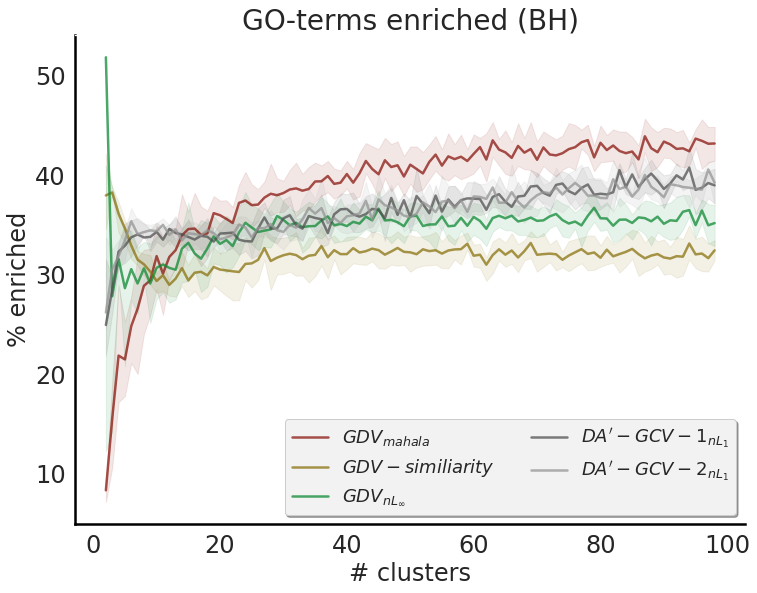

In [146]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(GO_coverages[feature][distance].index, 100*GO_coverages[feature][distance].T.mean(), 
            label = f'${name2string[method]}$', 
            color = colors[method], 
            alpha = 0.75,
            linewidth=2.5);
    
    ax.fill_between(GO_coverages[feature][distance].index, 
                     100*GO_coverages[feature][distance].T.quantile(0.25), 
                     100*GO_coverages[feature][distance].T.quantile(0.75), 
                     color = colors[method], 
                     alpha = 0.1,);
    ax.set_title(f'GO-terms enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_GO-term.png")

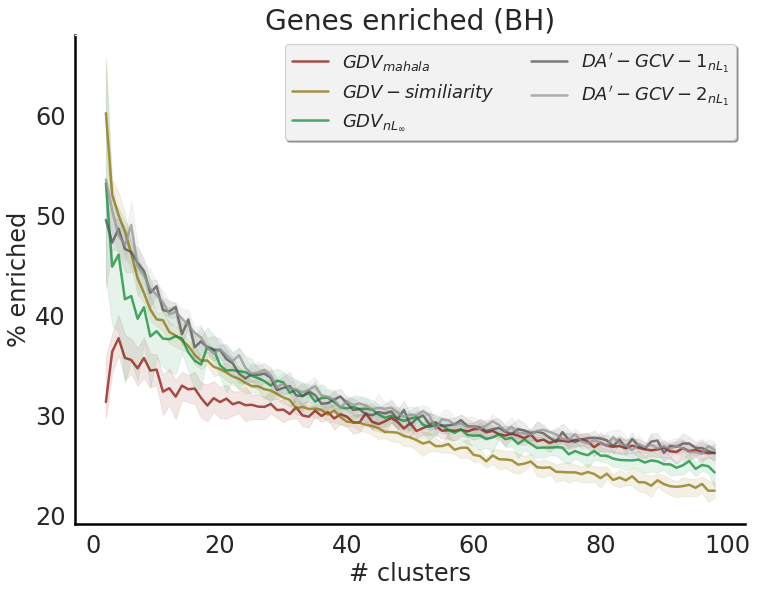

In [147]:
#Cluster coverage
figname = 'all'
fig, ax = plt.subplots(figsize=(12,9))
fig.patch.set_alpha(0)
fig.subplots_adjust(hspace = 0.4)

Blues = iter(sns.color_palette("Blues",6)[::-1])
Reds  = iter(sns.color_palette("Reds", 6)[::-1])

for method in plot_methods:
    
    feature  = method.split('_')[0]
    distance = '_'.join(method.split('_')[1:])
    
    ax.plot(gene_coverages[feature][distance].index, 100*gene_coverages[feature][distance].T.mean(), 
            label=f'${name2string[method]}$', 
            color = colors[method], 
            alpha = 0.75,
            linewidth = 2.5);
    
    ax.fill_between(gene_coverages[feature][distance].index,
                     100*gene_coverages[feature][distance].T.quantile(0.25), 
                     100*gene_coverages[feature][distance].T.quantile(0.75), 
                     color = colors[method], 
                     alpha = 0.1,);
    ax.set_title(f'Genes enriched ({correction})', fontsize=28)
     
    ax.patch.set_alpha(0)

    ax.set_xlabel('# clusters', fontsize=24)
    ax.set_ylabel('% enriched', fontsize=24)
    ax.tick_params(axis='both', which='major', labelsize=24)

    ax.spines['left'].set_linewidth(2.5)
    ax.spines['left'].set_color('black')

    ax.spines['bottom'].set_linewidth(2.5)
    ax.spines['bottom'].set_color('black')
    
    ax.legend(fontsize=18, shadow=True, facecolor=[0.95, 0.95, 0.95, 0], ncol=2);
fig.savefig(f"{DATA_DIRECTORY}/plots/{figname}_gene.png")